Используемый датасет: https://www.kaggle.com/tmdb/tmdb-movie-metadata/data

In [1]:
!ls tmdb-5000-movie-dataset

tmdb_5000_credits.csv tmdb_5000_movies.csv


In [2]:
%matplotlib inline

import json
import datetime
import pandas as pd
import numpy as np

# Visualization libs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

palette = sns.hls_palette(8, l=0.7, s=.8)
sns.set(rc={"figure.figsize": (6, 6)}, palette=palette)
sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = (10, 5)

In [3]:
def safe_access(container, index_values):
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except:
        return pd.np.nan

def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

def load_actors(path):
    df = pd.read_csv(path)
    for column in ['cast', 'crew']:
        df[column] = df[column].apply(json.loads)
    return df

def load_movies(path):
    df = pd.read_csv(path)
    df = df[df['status'] == 'Released']
    
    # удаляем ненужные поля (которые чаще всего не заполнены)
    del df['homepage']
    del df['tagline']
    # теперь незаполненных полей меньше, дропаем их
    df.dropna(inplace=True)

    df['genres'] = df['genres'].apply(json.loads).apply(lambda genres: sorted([x['name'] for x in genres]))
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    df['year'] = pd.to_datetime(df['release_date']).apply(lambda x: x.year)
    return df

df = load_movies('tmdb-5000-movie-dataset/tmdb_5000_movies.csv')
actors = load_actors('tmdb-5000-movie-dataset/tmdb_5000_credits.csv')
df['director'] = actors['crew'].apply(get_director)

df.head(3)

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,year,director
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Avatar,7.2,11800,2009,James Cameron
1,300000000,"[Action, Adventure, Fantasy]",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Pirates of the Caribbean: At World's End,6.9,4500,2007,Gore Verbinski
2,245000000,"[Action, Adventure, Crime]",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Spectre,6.3,4466,2015,Sam Mendes


# Самые "доходные" режиссёры
С помощью баббл-чарта мы можем показать сразу три величины.  
В нашем случае это суммарный бюджет фильмов режиссёра, суммарные доходы с этих фильмов и количество фильмов.

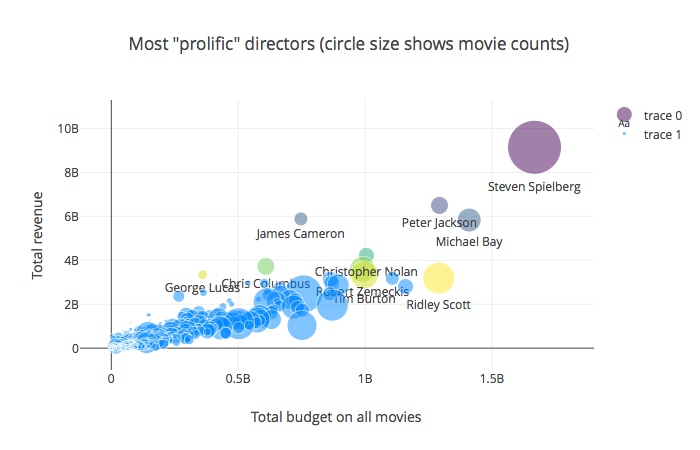

In [4]:
directors = df[df.revenue.gt(0) & df.budget.gt(0)].groupby('director')
directors = directors[['title', 'revenue', 'budget']].aggregate({ 'title': 'count', 'revenue': 'sum', 'budget': 'sum' })
directors = directors.sort_values(by='revenue', ascending=False)

top_directors = directors[:10]
rest_directors = directors[10:]

###

trace0 = go.Scatter(
    x=top_directors.budget,
    y=top_directors.revenue,
    mode = 'markers+text',
    text = top_directors.index,
    textposition='bottom',
    marker = dict(
        size = 2 * top_directors.title,
        color = 100/top_directors.revenue,
        colorscale='Viridis',
        opacity = 0.5,
    )
)

trace1 = go.Scatter(
    x=rest_directors.budget,
    y=rest_directors.revenue,
    mode = 'markers',
    text = rest_directors.index,
    marker = dict(
        size = 2 * rest_directors.title,
        color = '#08f',
        opacity = 0.5,
    )
)

data = [trace0, trace1]
layout = {
    'title': 'Most "prolific" directors (circle size shows movie counts)',
    'xaxis': {'title': 'Total budget on all movies'},
    'yaxis': {'title': 'Total revenue'}
}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

# Количество вышедших фильмов по годам
Для отображения "трендов" подходит line-chart, так как на нём лучше прослеживаются "взлёты" и "падения"

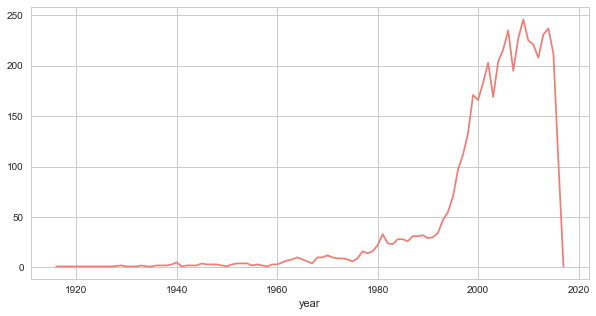

In [5]:
df_by_year = df.groupby('year')['id'].count()
df_by_year.plot()

# Распределение оценок
Для визуализации распределения частот подходит гистограмма

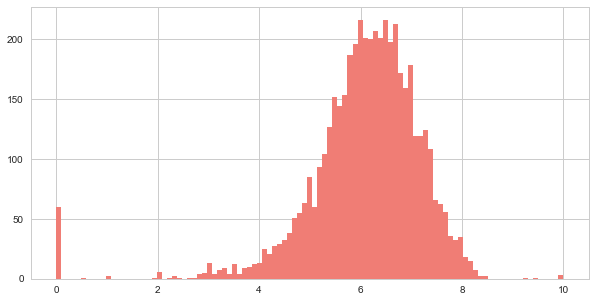

In [6]:
df["vote_average"].hist(bins=101)

# Корреляция оценок пользователей с годами
(также отфильтровываем фильмы, где слишком мало отзывов)

Используем joint-plot, чтобы вывести гистограммы каждой из величин и увидеть какие оценки чаще ставят старым и новым фильмам.

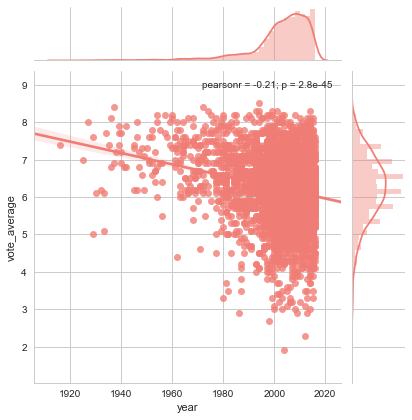

In [7]:
df_with_enough_votes = df[df['vote_count'].gt(10)]
sns.jointplot(x='year', y='vote_average', data=df_with_enough_votes, kind='reg')

Из графика, что старым фильмам оценки ставят реже и они выше, чем для новых фильмов. Скорее всего связано с тем, что из старых фильмов смотрят (и оценивают) только хорошую классику или же просто из-за ностальгии.

# Кассовые сборы по жанрам
Так как у фильмов проставлено несколько жанров, "продублируем" фильм для каждого из них

In [8]:
# Выбираем дублировать ли записи для каждого
# жанра или просто брать первый жанр из списка
choose_first = True

if choose_first:
    df_by_genre = df[['genres', 'budget', 'revenue', 'title']].reset_index()
    df_by_genre['genres'] = df_by_genre['genres'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')
    df_by_genre['revenue'] = df_by_genre['revenue'] / 1e6 # показываем в миллионах
else:
    movies_by_genre = []
    for key, row in df[['id', 'genres', 'budget', 'revenue']].iterrows():
        for genre in set(row.genres):
            new_row = row.copy()
            new_row['genres'] = genre
            new_row['revenue'] /= 1e6
            movies_by_genre.append(new_row)
    df_by_genre = pd.DataFrame(movies_by_genre)

Используем в данном случае box-plot, чтобы увидеть в каком интервале кассовых сборов лежит большинство фильмов в определённой категории

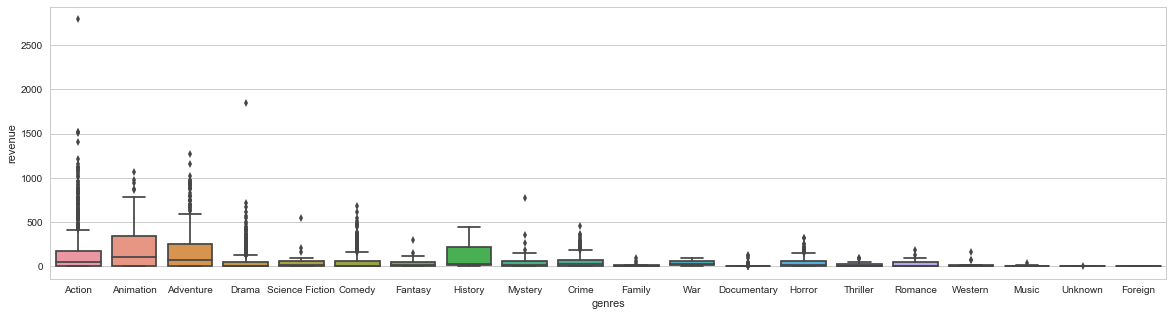

In [9]:
plt.rcParams["figure.figsize"] = (20, 5)
sns.boxplot(data=df_by_genre, x='genres', y='revenue')

И те же боксплоты, только отрисованные с помощью `plotly`

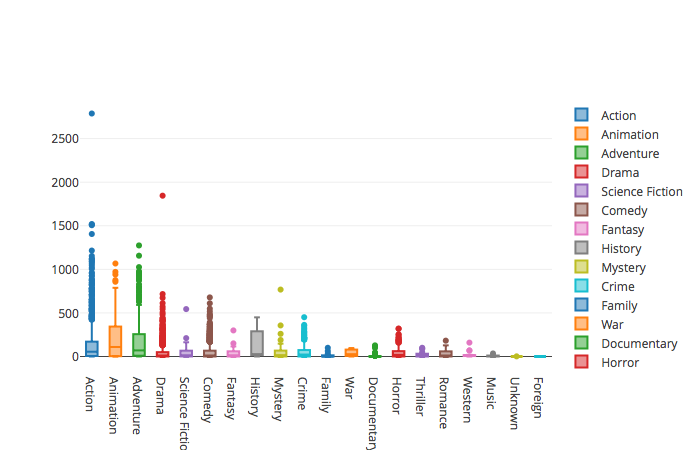

In [10]:
genres = df_by_genre.genres.unique()
data = [go.Box(y=df_by_genre[df_by_genre.genres == genre].revenue, name=genre) for genre in genres]
iplot(data, show_link=False)

# В каких годах какие жанры выходили чаще
(по десятилетиям)

Используеум здесь heatmap, чтобы более явно видеть количество фильмов в нужном жанре.  
Для данных сгруппированным по категориям он подходит лучше чем Bubble-chart и scatter-plot, а также позволяет сразу увидеть точные числа.

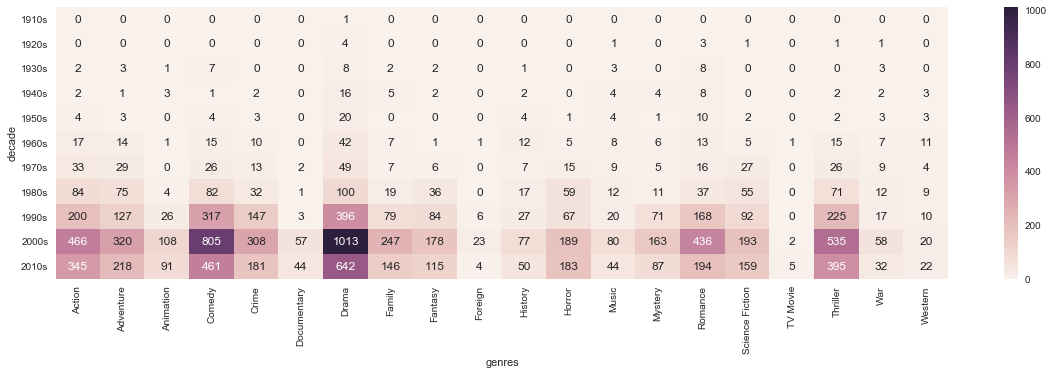

In [11]:
movies_by_genre = []
for key, row in df[['id', 'year','genres']].iterrows():
    for genre in set(row.genres):
        new_row = row.copy()
        new_row['genres'] = genre
        movies_by_genre.append(new_row)

df_by_genre_years = pd.DataFrame(movies_by_genre)

decade = 10 * (df_by_genre_years['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'

df_by_genre_years = df_by_genre_years.groupby([decade, 'genres'])['genres'].count().unstack().fillna(0)

sns.heatmap(df_by_genre_years, annot=True, fmt='.0f', cmap=sns.cubehelix_palette(light=0.95, as_cmap=True))